In [194]:
import numpy as np
import heapq
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(2)   

In [195]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0],  # From A
    [0.20, 0.00, 0.50, 0.15, 0.15, 0],  # From B
    [0.30, 0.20, 0.00, 0.20, 0.30, 0],  # From C
    [0.35, 0.30, 0.05, 0.00, 0.30, 0],  # From D
    [0.20, 0.10, 0.60, 0.10, 0.00, 0],  # From E
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
])

lambdas = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length_of_stay = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]
bed_capacity = [55, 40, 35, 20, 20, 0]

# Example: types A–E map to wards 0–4, and type F (index 5) maps to ward 5
primary_wards = [0, 1, 2, 3, 4, 5]

days_simulation = 100
n_replications = 50

urgency_point = [7, 5, 2, 10, 5]

In [196]:

# Global flags for LOS distribution
use_lognormal = False   # If False: exponential; if True: log-normal
k_variance = 1          # Variance multiple for log-normal (k >= 1)

In [197]:
def arrival_time(lambda_):
    if lambda_ <= 0:
        return np.inf
    return np.random.exponential(1.0 / lambda_)

def time_of_stay(mu):
    if mu <= 0:
        return np.inf
    if not use_lognormal:
        return np.random.exponential(mu)
    else:
        # log-normal parameters so that E[X]=mu, Var[X]=k_variance * mu^2
        s2 = np.log(k_variance + 1)
        sigma = np.sqrt(s2)
        mu_ln = np.log(mu) - 0.5 * s2
        return np.random.lognormal(mu_ln, sigma)

def simulate_arrival_time_day(lambda_, days_simulation):
    total = 0.0
    arrivals_time = []
    if lambda_ <= 0:
        return np.array(arrivals_time)
    while total < days_simulation:
        ia = arrival_time(lambda_)
        total += ia
        if total > days_simulation:
            break
        arrivals_time.append(total)
    return np.array(arrivals_time)

def extract_new_ward(patient_type, transition_probability):
    P_row = np.array(transition_probability[patient_type], dtype=float)
    n_wards = P_row.shape[0]
    total = P_row.sum()
    if total <= 0:
        raise ValueError(f"Transition probabilities for type {patient_type} sum to {total}")
    P_norm = P_row / total
    choices = np.arange(n_wards)
    new_ward = np.random.choice(choices, p=P_norm)
    return new_ward

def list_arrive_patient(arrivals_time):
    result = []
    for tp, arr in enumerate(arrivals_time):
        for t in arr:
            result.append((t, tp))
    result.sort(key=lambda x: x[0])
    return result

def count_new_departures(leaving_time, processed, current_time, n_wards):
    departures_count = np.zeros(n_wards, dtype=int)
    for idx, ((dep_time, ward_idx), was_processed) in enumerate(zip(leaving_time, processed)):
        if (not was_processed) and (dep_time < current_time):
            if ward_idx < 0 or ward_idx >= n_wards:
                raise IndexError(f"Departure event has invalid ward_idx {ward_idx}")
            departures_count[ward_idx] += 1
            processed[idx] = True
    return departures_count, processed


In [198]:
def simulate(
    transition_probability,
    lambdas,
    mean_length_stay,
    bed_capacity,
    days_simulation
):
    n_types = len(lambdas)
    n_wards = len(bed_capacity)
    # Convert to numpy
    P = np.array(transition_probability, dtype=float)
    # Sanity checks
    assert len(mean_length_stay) == n_types, "mean_length_stay length mismatch"
    assert P.shape == (n_types, n_wards), f"P must be shape ({n_types},{n_wards}), got {P.shape}"
    # Primary ward mapping: identity type i->ward i. Requires n_types == n_wards.
    if n_types != n_wards:
        raise ValueError(f"For identity primary mapping need n_types==n_wards; got {n_types} types, {n_wards} wards")
    primary_wards = list(range(n_types))
    # Arrival times per type
    arrival_time_total = [
        simulate_arrival_time_day(lambdas[tp], days_simulation)
        for tp in range(n_types)
    ]
    mix_arrivals = list_arrive_patient(arrival_time_total)
    # State tracking
    occupied_bed = np.zeros(n_wards, dtype=int)
    rejected_patients = np.zeros(n_types, dtype=int)
    relocated_patients = np.zeros((n_types, n_wards), dtype=int)
    # Time series
    occupied_bed_timeline = []
    rejected_patients_timeline = []
    time_timeline = []
    # Departure tracking
    leaving_time = []   # list of (departure_time, ward_idx)
    processed = []      # list of bools
    # Process arrivals
    for arrival_time, patient_type in mix_arrivals:
        # Free departures
        departures_count, processed = count_new_departures(
            leaving_time, processed, arrival_time, n_wards
        )
        occupied_bed -= departures_count
        # Primary ward
        pw = primary_wards[patient_type]
        if occupied_bed[pw] < bed_capacity[pw]:
            # Admit primary
            occupied_bed[pw] += 1
            stay = time_of_stay(mean_length_stay[patient_type])
            dep_t = arrival_time + stay
            leaving_time.append((dep_t, pw))
            processed.append(False)
        else:
            # Relocate among 0..n_wards-1
            new_ward = extract_new_ward(patient_type, P)
            # Attempt admit to new_ward
            if occupied_bed[new_ward] < bed_capacity[new_ward]:
                occupied_bed[new_ward] += 1
                stay = time_of_stay(mean_length_stay[patient_type])
                dep_t = arrival_time + stay
                leaving_time.append((dep_t, new_ward))
                processed.append(False)
                relocated_patients[patient_type, new_ward] += 1
            else:
                # Reject
                rejected_patients[patient_type] += 1
        # Record snapshot
        occupied_bed_timeline.append(occupied_bed.copy())
        rejected_patients_timeline.append(rejected_patients.copy())
        time_timeline.append(arrival_time)
    # Convert timelines to arrays
    return (
        np.array(occupied_bed_timeline),
        np.array(rejected_patients_timeline),
        np.array(time_timeline),
        leaving_time,
        relocated_patients,
        mix_arrivals
    )

def compute_cost(rej_hist, reloc_matrix, urgency_point):
    if len(rej_hist) > 0:
        final_rej = rej_hist[-1]
    else:
        final_rej = np.zeros(len(urgency_point), dtype=int)
    relocated = reloc_matrix.sum(axis=1)
    up = np.array(urgency_point, dtype=float)
    return float(np.dot(final_rej + relocated, up))

#Sensitivity analysis
def run_one_sim():
    occ_tl, rej_tl, time_tl, leaving_time, reloc_mat, mix_arrivals = simulate(
        transition_probability=P,
        lambdas=lambdas,
        mean_length_stay=mean_length_of_stay,
        bed_capacity=bed_capacity,
        days_simulation=days_simulation
    )
    # total rejections & relocations
    if len(rej_tl) > 0:
        final_rej = rej_tl[-1]
    else:
        final_rej = np.zeros(len(lambdas), dtype=int)
    total_rej = int(final_rej.sum())
    total_reloc = int(reloc_mat.sum())
    cost = compute_cost(rej_tl, reloc_mat, urgency_point)
    return total_rej, total_reloc, cost

def run_sensitivity(k_values, n_replications=50, base_seed=2):
    records = []
    for k in k_values:
        global use_lognormal, k_variance
        use_lognormal = True
        k_variance = k
        rej_list = []
        reloc_list = []
        cost_list = []
        for rep in range(n_replications):
            seed = base_seed + rep
            np.random.seed(seed)
            total_rej, total_reloc, cost = run_one_sim()
            rej_list.append(total_rej)
            reloc_list.append(total_reloc)
            cost_list.append(cost)
        records.append({
            'k': k,
            'mean_rej': np.mean(rej_list), 'std_rej': np.std(rej_list, ddof=1),
            'mean_reloc': np.mean(reloc_list), 'std_reloc': np.std(reloc_list, ddof=1),
            'mean_cost': np.mean(cost_list), 'std_cost': np.std(cost_list, ddof=1)
        })
    df = pd.DataFrame(records) # Getting a dataframe for nice visibility
    return df

In [193]:
# Main function with parameters
if __name__ == "__main__":
    lambdas = lambdas        
    mean_length_stay = mean_length_of_stay 
 
    urgency_point = [7, 5, 2, 10, 5, 0]

    bed_capacity = bed_capacity
    
    P = np.array([
        [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],  # From A
        [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],  # From B
        [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],  # From C
        [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],  # From D
        [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],  # From E
        [0.20, 0.20, 0.20, 0.20, 0.20, 0.00],  # From F* (initial relocation probabilities)
    ])
    # Normalize rows 
    P = P / P.sum(axis=1, keepdims=True)

    # Simulation and replication
    days_simulation = days_simulation
    n_replications = n_replications

#Parameter checks
    n_types = len(lambdas)
    n_wards = len(bed_capacity)
    assert n_types == n_wards, f"Need same number of types and wards for identity mapping; got {n_types} types, {n_wards} wards"
    assert P.shape == (n_types, n_wards), f"P must be shape ({n_types},{n_wards}), got {P.shape}"
    assert len(mean_length_stay) == n_types
    assert len(urgency_point) == n_types

# BAseline
    use_lognormal = False
    k_variance = 1
    rej_list = []
    reloc_list = []
    cost_list = []
    for rep in range(n_replications):
        np.random.seed(2 + rep)
        total_rej, total_reloc, cost = run_one_sim()
        rej_list.append(total_rej)
        reloc_list.append(total_reloc)
        cost_list.append(cost)
    df_base = pd.DataFrame({
        'rej': rej_list, 'reloc': reloc_list, 'cost': cost_list
    })
    print("Baseline summary over", n_replications, "replications:")
    print(df_base.describe())

    # Sensitivity: log-normal LOS with variance multiples k
    k_values = [1, 2, 3, 4]  # k=1 yields var=1/mu^2 (same as exponential var), larger k heavier tail
    print("\nRunning sensitivity (log-normal LOS) for k =", k_values)
    df_sens = run_sensitivity(k_values, n_replications=n_replications, base_seed=100)
    display(df_sens)

    # Plot mean cost vs k
    plt.figure()
    plt.errorbar(df_sens['k'], df_sens['mean_cost'], yerr=df_sens['std_cost'], fmt='-o')
    plt.xlabel('k (variance multiple for log normal LOS)')
    plt.ylabel('Mean cost +- 1 std')
    plt.title('Sensitivity of cost to LOS variance')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Plot of mean_rej, mean_reloc vs k:
    plt.figure()
    plt.plot(df_sens['k'], df_sens['mean_rej'], marker='o', label='mean rejections')
    plt.plot(df_sens['k'], df_sens['mean_reloc'], marker='s', label='mean relocations')
    plt.xlabel('k (variance multiple)')
    plt.ylabel('Count')
    plt.title('Sensitivity: rejections and relocations vs LOS variance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

 

Running baseline (exponential LOS)...
Baseline summary over 50 replications:
             rej       reloc         cost
count   50.00000    50.00000    50.000000
mean   714.92000  1637.52000  5262.480000
std     63.00173    34.47403   394.716599
min    590.00000  1574.00000  4156.000000
25%    678.50000  1607.75000  5014.250000
50%    719.00000  1637.00000  5310.500000
75%    757.00000  1665.00000  5541.000000
max    836.00000  1713.00000  5935.000000

Running sensitivity (log-normal LOS) for k = [1, 2, 3, 4]


KeyboardInterrupt: 

Last Sensitivity Analysis

In [ ]:
def evaluate_total_beds(
    base_bed_capacity_AtoE,
    lambdas,
    mean_length_stay,
    urgency_point,
    P,
    days_simulation,
    n_replications,
    target_totals,
    base_seed=1000
):
    records = []
    sum_AtoE = sum(base_bed_capacity_AtoE)
    n_types = len(lambdas)
    # Sanity: we assume n_types == 6
    assert n_types == 6, "Expected 6 patient types"
    for total_beds in target_totals:
        cap_F = total_beds - sum_AtoE
        if cap_F < 0:
            # Skipping scenarios where total beds < sum of A–E capacities
            print(f"Skipping total_beds={total_beds} since cap_F={cap_F} < 0")
            continue
        # Bed capacity list length 6: A–E from base F_star = cap_F
        bed_capacity_scenario = base_bed_capacity_AtoE + [cap_F]
        # Sanity check length
        assert len(bed_capacity_scenario) == 6

        global bed_capacity
        bed_capacity = bed_capacity_scenario
        
        # Check shapes if desired:
        rej_list = []
        reloc_list = []
        cost_list = []
        for rep in range(n_replications):
            seed = base_seed + rep
            np.random.seed(seed)
            total_rej, total_reloc, cost = run_one_sim()
            rej_list.append(total_rej)
            reloc_list.append(total_reloc)
            cost_list.append(cost)
        # Record results
        records.append({
            'total_beds': total_beds,
            'cap_F': cap_F,
            'mean_rej': np.mean(rej_list), 'std_rej': np.std(rej_list, ddof=1),
            'mean_reloc': np.mean(reloc_list), 'std_reloc': np.std(reloc_list, ddof=1),
            'mean_cost': np.mean(cost_list), 'std_cost': np.std(cost_list, ddof=1)
        })
        print(f"Completed total_beds={total_beds}, cap_F={cap_F}: mean_rej={np.mean(rej_list):.2f}, mean_cost={np.mean(cost_list):.2f}")
    df = pd.DataFrame(records)
    return df


Skipping total_beds=150 since cap_F=-15 < 0
Completed total_beds=165, cap_F=0: mean_rej=685.54, mean_cost=4881.80
Completed total_beds=170, cap_F=5: mean_rej=578.14, mean_cost=4381.06
Completed total_beds=180, cap_F=15: mean_rej=368.30, mean_cost=3407.78

Results for varying total beds:


,total_beds,cap_F,mean_rej,std_rej,mean_reloc,std_reloc,mean_cost,std_cost
0,165,0,685.54,113.111145,1627.38,50.285670,4881.80,722.560018
1,170,5,578.14,89.898358,1424.58,49.455439,4381.06,558.293918
2,180,15,368.30,73.619887,1036.22,55.185509,3407.78,547.722866


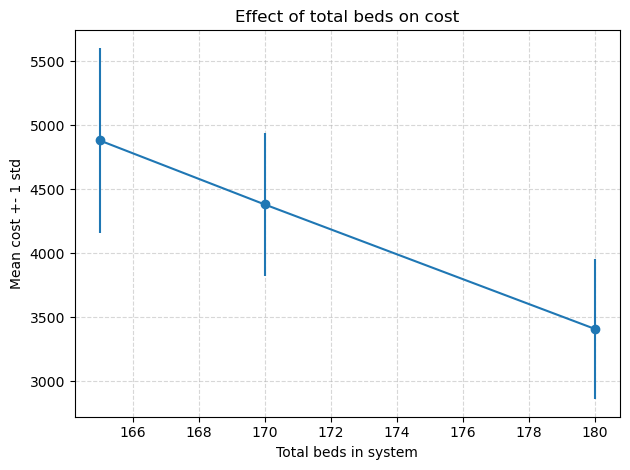

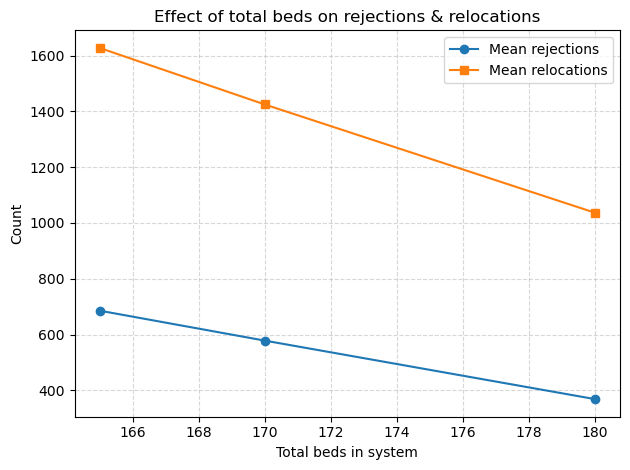

In [ ]:
# Base capacities for A–E from our matrix
base_bed_capacity_AtoE = [55, 40, 30, 20, 20]

# Bed capasities, 165 is normal
target_totals = [150, 165, 170, 180]  

df_bed = evaluate_total_beds(
    base_bed_capacity_AtoE=base_bed_capacity_AtoE,
    lambdas=lambdas,
    mean_length_stay=mean_length_stay,
    urgency_point=urgency_point,
    P=P,
    days_simulation=days_simulation,
    n_replications=n_replications,
    target_totals=target_totals,
    base_seed=2000
)

print("\nResults for varying total beds:")
display(df_bed)

# Plot metrics vs total_beds
plt.figure()
plt.errorbar(df_bed['total_beds'], df_bed['mean_cost'], yerr=df_bed['std_cost'], fmt='-o', label='Cost')
plt.xlabel('Total beds in system')
plt.ylabel('Mean cost +- 1 std')
plt.title('Effect of total beds on cost')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df_bed['total_beds'], df_bed['mean_rej'], '-o', label='Mean rejections')
plt.plot(df_bed['total_beds'], df_bed['mean_reloc'], '-s', label='Mean relocations')
plt.xlabel('Total beds in system')
plt.ylabel('Count')
plt.title('Effect of total beds on rejections & relocations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
